In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import local_linear
import scipy.spatial as spatial
import glob
import copy
import imageio
import os 

In [2]:
starts = {'25':[1187,3119,4684,6591,8931],'57':[3043],'76':[1249,3230,4943,6587,8487],'89':[855,2393,3914,5456,6990,8508]}
loc = 'data/'

In [3]:
lenny = 200
dater = []
for k in starts.keys():
    for start in starts[k]:
        data = np.zeros((lenny,1,480,640))
        for q in range(lenny):
            data[q]=imageio.imread(os.path.join(loc,k,f'frames{q+start:07}.png'))[-480:,:,1]
        dater.append(copy.copy(data))


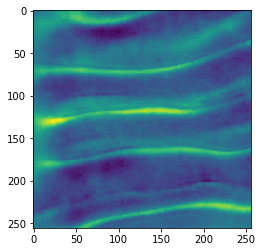

In [4]:
plt.figure()
plt.imshow(dater[0][0,0,100:356,150:406])
plt.show()

In [5]:
wid = 0
dat = np.stack([d[:200+(wid*2):2,0:,100:356,150:406] for d in dater],axis=1)
#sdat = np.zeros_like(dat)
#for q in range(len(dat)-wid):
#    sdat[q] = np.mean(dat[q:(q+wid)],axis=0)
#dat = sdat
dat = dat.reshape([17*(100),256,256,1])
dat.shape

(1700, 256, 256, 1)

In [6]:
chipsizes=[8,8,4]
n_components=[12,64,0]
reduces = [10,5,1]
#n_components=[12,32,64]
#reduces = [5,5,2]

In [7]:
chipsizes=[8,8,4]
n_components=[12,64,0]
reduces = [10,5,1]
#n_components=[12,32,64]
#reduces = [5,5,2]

pcap = local_linear.PCA_pyramid(reduces=reduces,chipsizes=chipsizes,n_components=n_components)

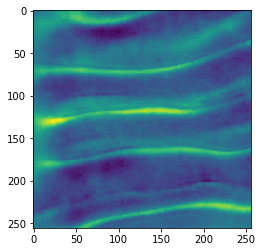

In [8]:
plt.figure()
plt.imshow(dat[0][:,:,0])
plt.show()

In [11]:
daty = pcap.fit_transform(dat)

Starting level 0
Starting level 1
Starting level 2
503


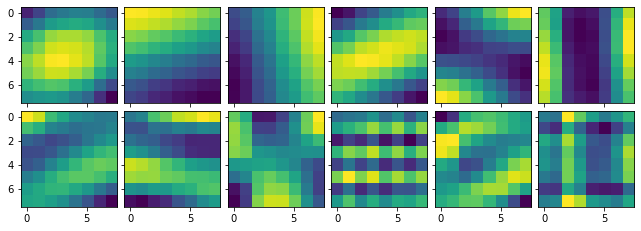

In [27]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(11., 11.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, pcap.pcas[0].components_):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.reshape([8,8]))
    plt.axis('off')

plt.show()

In [47]:
from itertools import product
things = []
for q in range(64):
    state_vec = np.zeros((1,1,1,64))
    state_vec[0,0,0,q] = 1
    current_size = np.array([1,1])
    quant = state_vec.shape[0]
    for pca,n_component,chipsize in zip(pcap.pcas[-2::-1],n_components[-3::-1],chipsizes[-2::-1]):
        state_vec = state_vec@pca.components_
        current_size = current_size*chipsize
        rvid = np.zeros([quant,current_size[0],current_size[1],n_component])
        grid = product(range(0, current_size[0], chipsize), range(0, current_size[1], chipsize))
        for n,ij in enumerate(grid):
            i,j = ij 
            rvid[:,i:(i+chipsize),j:(j+chipsize)]=state_vec[:,i//chipsize,j//chipsize,:].reshape([-1,chipsize,chipsize,n_component])
        state_vec = copy.copy(rvid)
    things.append(np.squeeze(state_vec))
    


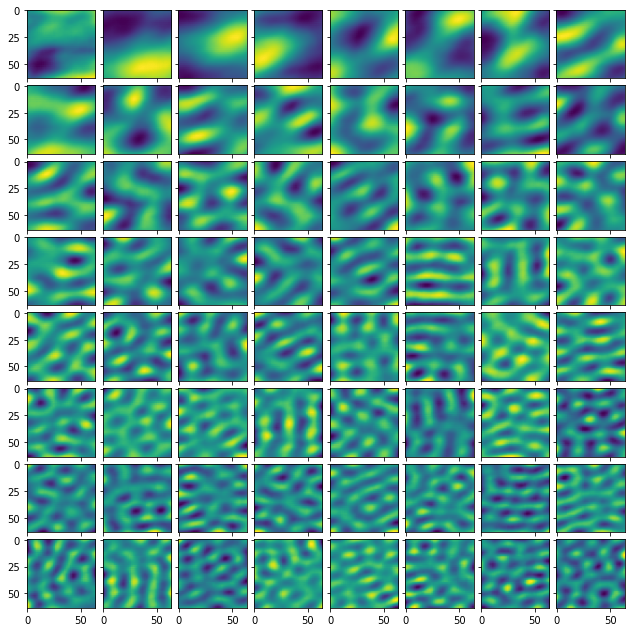

In [50]:

fig = plt.figure(figsize=(11., 11.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, things):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.reshape([64,64]))
    plt.axis('off')

plt.show()

In [51]:
from itertools import product
things = []
for q in range(64):
    state_vec = np.zeros((1,1,1,503))
    state_vec[0,0,0,q] = 1
    current_size = np.array([1,1])
    quant = state_vec.shape[0]
    for pca,n_component,chipsize in zip(pcap.pcas[-1::-1],n_components[-2::-1],chipsizes[-1::-1]):
        state_vec = state_vec@pca.components_
        current_size = current_size*chipsize
        rvid = np.zeros([quant,current_size[0],current_size[1],n_component])
        grid = product(range(0, current_size[0], chipsize), range(0, current_size[1], chipsize))
        for n,ij in enumerate(grid):
            i,j = ij 
            rvid[:,i:(i+chipsize),j:(j+chipsize)]=state_vec[:,i//chipsize,j//chipsize,:].reshape([-1,chipsize,chipsize,n_component])
        state_vec = copy.copy(rvid)
    things.append(np.squeeze(state_vec))



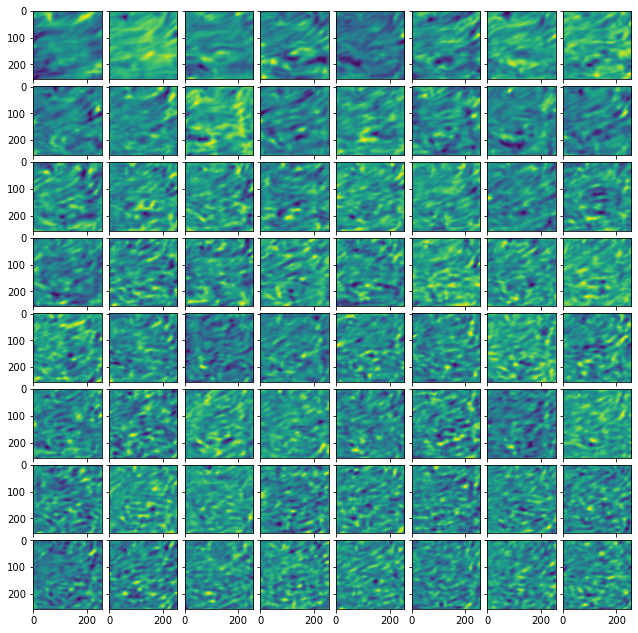

In [53]:

fig = plt.figure(figsize=(11., 11.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, things):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.reshape([256,256]))
    plt.axis('off')

plt.show()

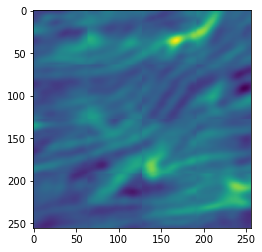

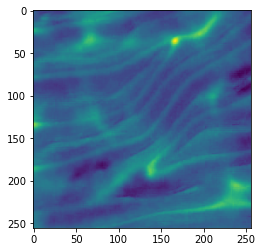

In [90]:
n = 200
r = pcap.reverse(daty[n:n+1])  #this keeps the dim
plt.figure()
plt.imshow(r.squeeze())#-dat[100].squeeze())
plt.show()
plt.figure()
plt.imshow(dat[n].squeeze())
plt.show()

In [91]:
dats = daty.reshape([100,17,-1])
filt = np.ones(5)
sdats = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='full'), axis=0, arr=dats)
sdats.shape

(104, 17, 503)

In [92]:
numframes=17
ps=100

In [93]:
#reload(local_linear)
As,frame_ass = local_linear.local_linear(dats,2,nearest=False)

[ 0.          0.35416667  0.70833333  1.0625      1.41666667  1.77083333
  2.125       2.47916667  2.83333333  3.1875      3.54166667  3.89583333
  4.25        4.60416667  4.95833333  5.3125      5.66666667  6.02083333
  6.375       6.72916667  7.08333333  7.4375      7.79166667  8.14583333
  8.5         8.85416667  9.20833333  9.5625      9.91666667 10.27083333
 10.625      10.97916667 11.33333333 11.6875     12.04166667 12.39583333
 12.75       13.10416667 13.45833333 13.8125     14.16666667 14.52083333
 14.875      15.22916667 15.58333333 15.9375     16.29166667 16.64583333
 17.        ]
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17


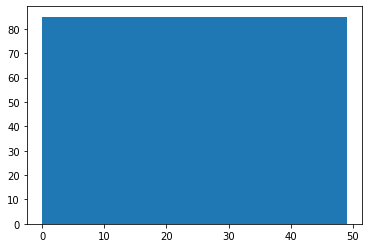

In [94]:
plt.figure()
plt.hist(frame_ass.flatten())
plt.show()

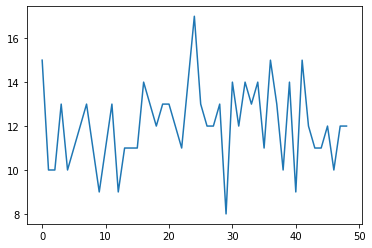

In [144]:
ne = []
mv = []
ee = []
nvec = 25
for A in As:
    e,v = np.linalg.eig(A[1:nvec,1:nvec])
    ne.append(len(np.where(np.real(e)>0)[0]))
    ee.append(e)
    mv.append(v)
    #plt.figure()
    #plt.plot(np.sort(np.real(e)))
    #plt.title(f'{len(np.where(np.real(e)>0)[0])} Positive')
    #plt.show()
plt.figure()
plt.plot(ne)
plt.show()

In [145]:
ve = []
vv = []
thr = .2
for q in range(48):
    ve.append([])
    vv.append([])
    for m in range(15):
        for n in range(15):
            if mv[q][m].dot(mv[q+1][n]) > thr:
                print(f"keeping {q},{m}")
                vv[-1].append(mv[q][m])
                ve[-1].append(ee[q][m])
                break

keeping 0,0
keeping 0,1
keeping 0,2
keeping 0,3
keeping 0,5
keeping 0,6
keeping 0,8
keeping 0,9
keeping 0,10
keeping 0,11
keeping 0,12
keeping 0,13
keeping 0,14
keeping 1,0
keeping 1,1
keeping 1,2
keeping 1,3
keeping 1,4
keeping 1,6
keeping 1,7
keeping 1,8
keeping 1,9
keeping 1,10
keeping 1,11
keeping 1,12
keeping 1,13
keeping 1,14
keeping 2,0
keeping 2,1
keeping 2,2
keeping 2,5
keeping 2,9
keeping 2,10
keeping 2,13
keeping 2,14
keeping 3,0
keeping 3,1
keeping 3,3
keeping 3,4
keeping 3,7
keeping 3,8
keeping 3,9
keeping 3,10
keeping 3,11
keeping 3,12
keeping 3,13
keeping 4,0
keeping 4,1
keeping 4,2
keeping 4,3
keeping 4,4
keeping 4,5
keeping 4,6
keeping 4,7
keeping 4,8
keeping 4,12
keeping 4,13
keeping 4,14
keeping 5,1
keeping 5,3
keeping 5,5
keeping 5,6
keeping 5,8
keeping 5,9
keeping 5,10
keeping 5,11
keeping 5,12
keeping 5,13
keeping 5,14
keeping 6,0
keeping 6,1
keeping 6,2
keeping 6,3
keeping 6,4
keeping 6,5
keeping 6,6
keeping 6,7
keeping 6,8
keeping 6,9
keeping 6,10
keeping 6,11
k

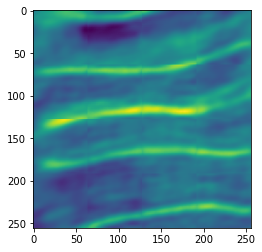

In [146]:
r = pcap.reverse(daty[n:n+1])  #this keeps the dim
plt.figure()
plt.imshow(r.squeeze())#-dat[100].squeeze())
plt.show()


In [7]:
import pickle
pickle.dump?

Signature:
pickle.dump(
    obj,
    file,
    protocol=None,
    *,
    fix_imports=True,
    buffer_callback=None,
)
Docstring:
Write a pickled representation of obj to the open file object file.

This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
be more efficient.

The optional *protocol* argument tells the pickler to use the given
protocol; supported protocols are 0, 1, 2, 3, 4 and 5.  The default
protocol is 4. It was introduced in Python 3.4, and is incompatible
with previous versions.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

The *file* argument must have a write() method that accepts a single
bytes argument.  It can thus be a file object opened for binary
writing, an io.BytesIO instance, or any other custom object that meets
this interface.

If *fix_imports* is True and protocol is less than 3, pickle will try

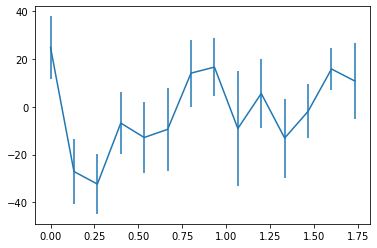

In [147]:
n = 14
sse = [np.mean(np.maximum(np.minimum(100,np.real(e)),-100)) for e in ve[:n]]
ssee = [np.std(np.maximum(np.minimum(100,np.real(e)),-100))/np.sqrt(17) for e in ve[:n]]
plt.figure()
plt.errorbar(np.arange(0,n*4,4)*1/30,sse,yerr=ssee)
plt.show()

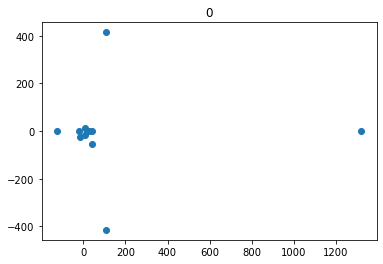

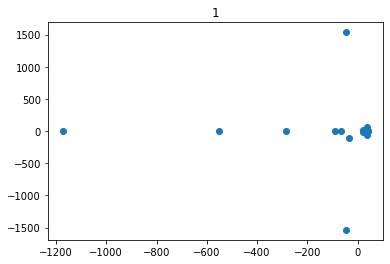

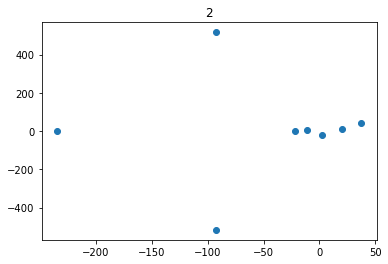

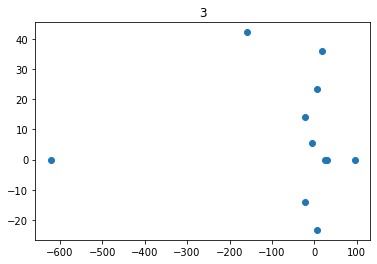

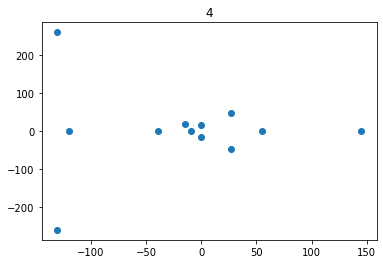

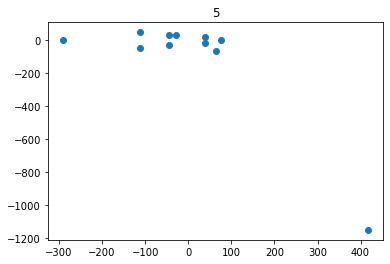

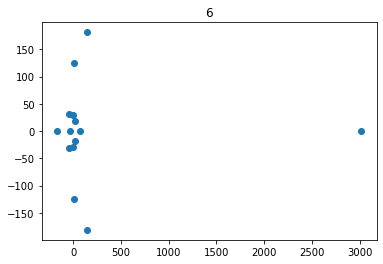

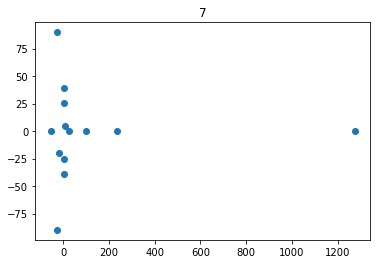

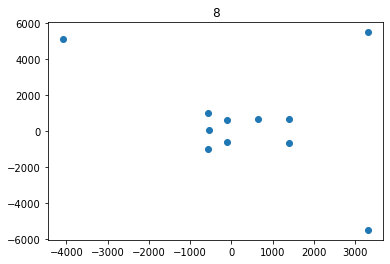

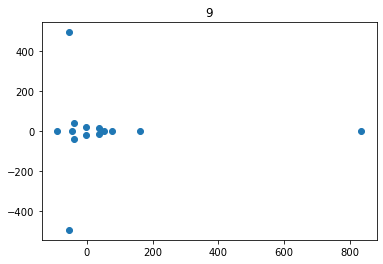

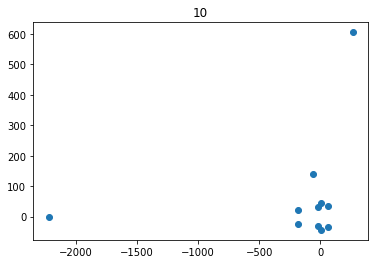

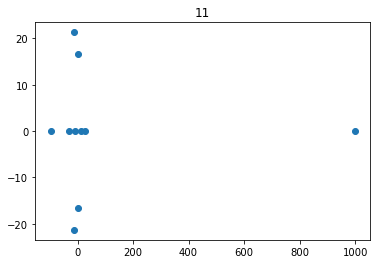

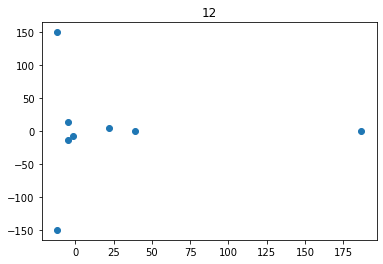

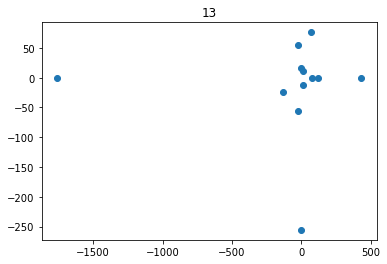

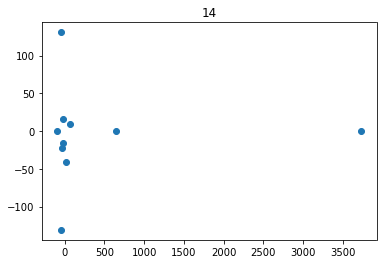

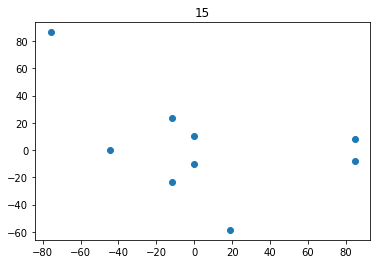

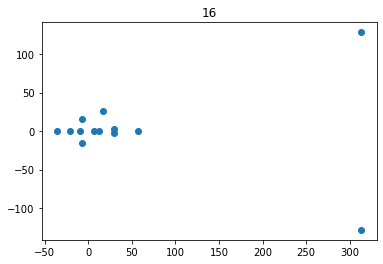

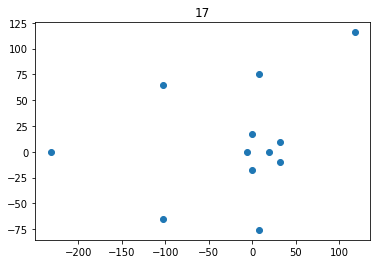

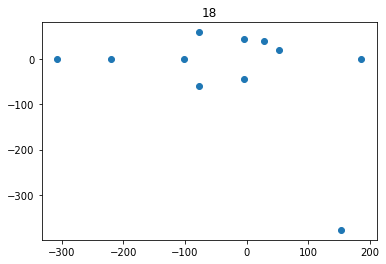

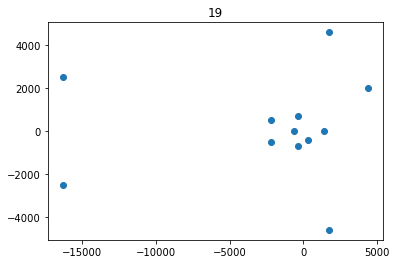

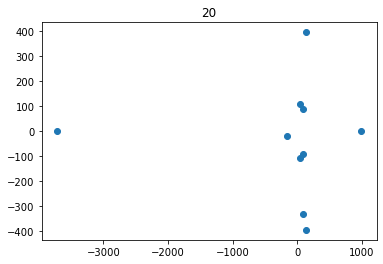

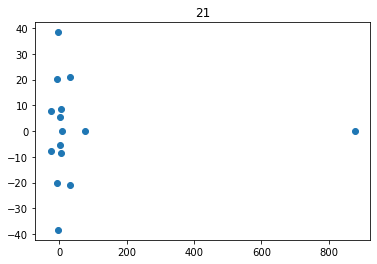

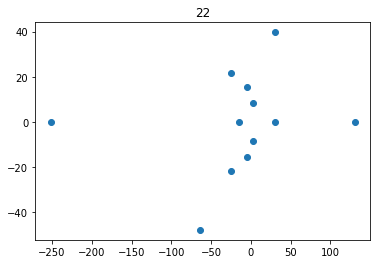

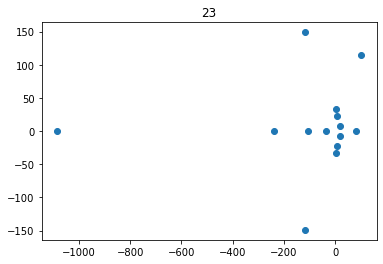

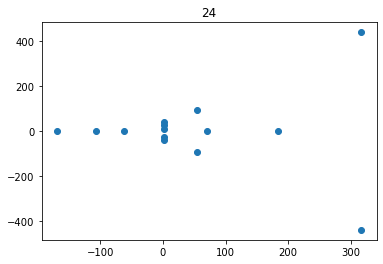

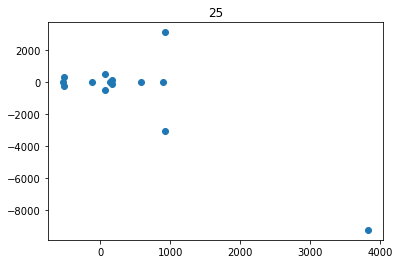

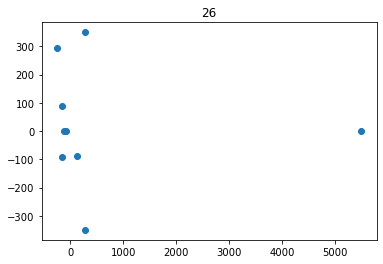

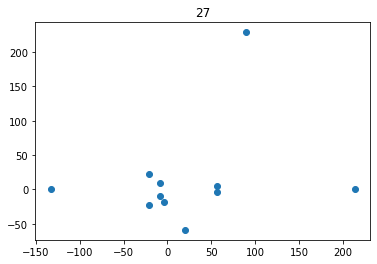

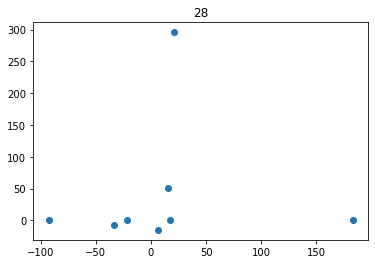

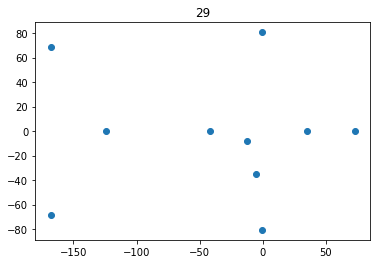

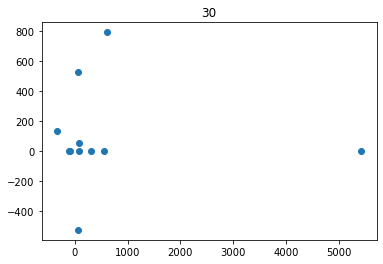

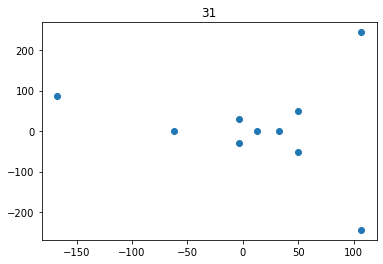

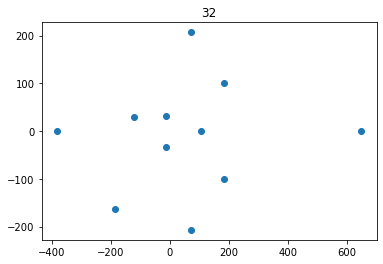

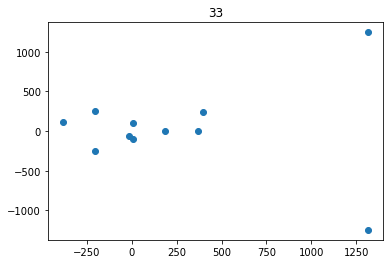

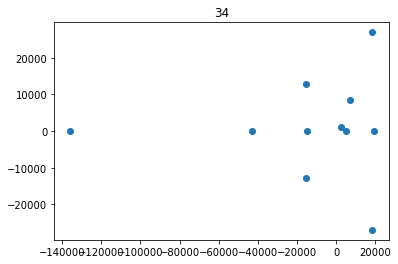

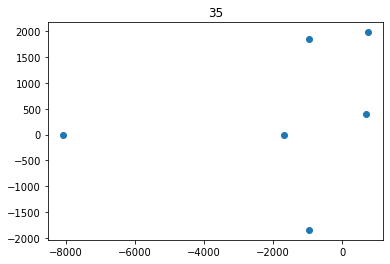

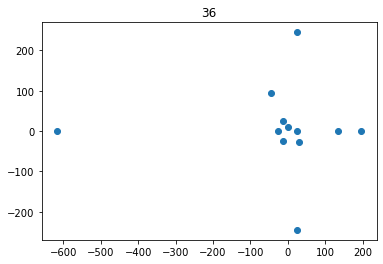

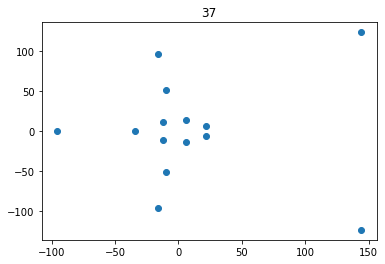

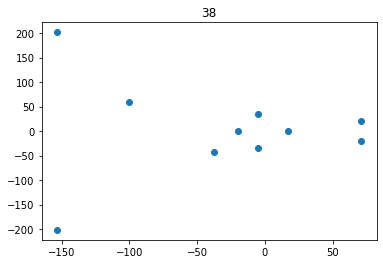

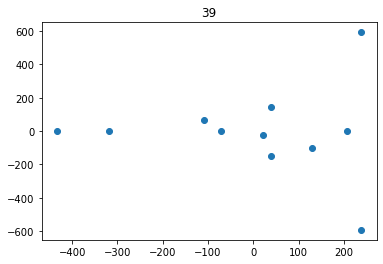

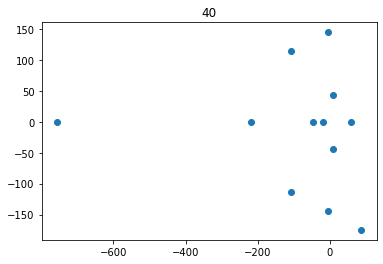

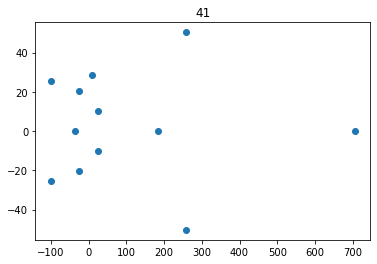

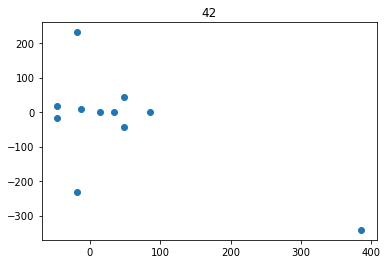

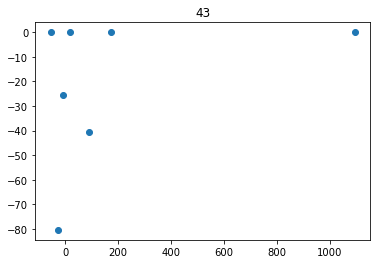

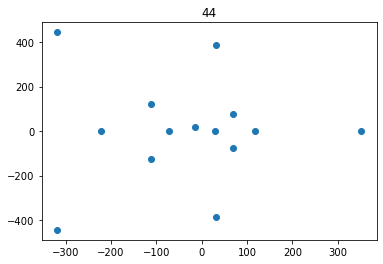

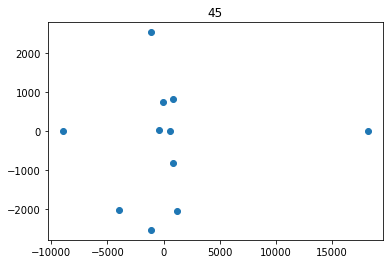

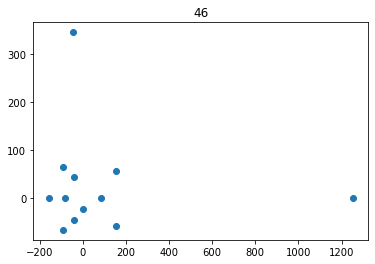

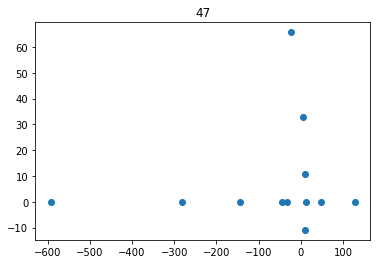

In [121]:
for n,te in enumerate(ve):
    plt.figure()
    plt.title(f'{n}')
    plt.scatter(np.real(te),np.imag(te))
    plt.show()

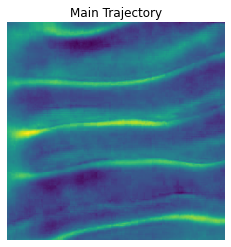

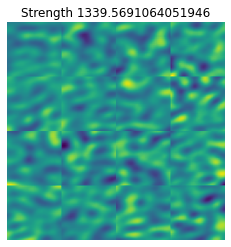

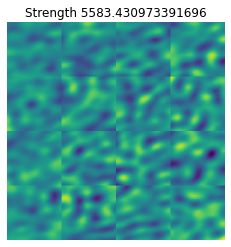

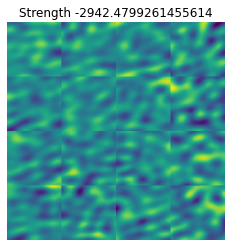

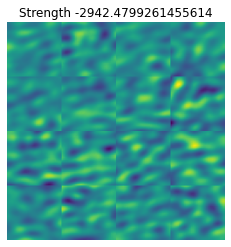

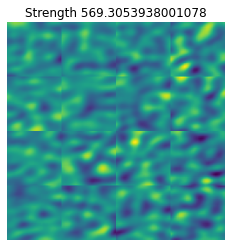

In [71]:
n = 0
plt.figure()
plt.imshow(dater[0][2*2*n,0,100:356,150:406].squeeze())
plt.title('Main Trajectory')
plt.axis('off')
#plt.savefig(f"data/traj{n}.png")
plt.show()
for q in range(5):
    thing = np.random.randn(*daty[0:1].shape)
    #thing = np.zeros_like(daty[0:1])
    #thing[0,1:32] = vv[n][q]
    r = pcap.reverse(thing)
    plt.figure()
    plt.title(f'Strength {np.real(ve[n][q])}')
    plt.imshow(r.squeeze())#-dat[100].squeeze())
    plt.axis('off')
    #plt.savefig(f"data/dir{n}_{q}.png")
    plt.show()


In [68]:
magic_ns = []
for nn in range(n,n+10):
    base = dats[n*2,0]
    magic_nns = []
    for vecn in range(5):
        thing = np.zeros_like(daty[0:1])
        thing[0,1:32] = vv[nn][vecn]
        vec = pcap.reverse(thing)
        dots = []
        for q in range(dats.shape[1]-1):
            dots.append(np.sum((dater[0][2*nn,0,100:356,150:406].squeeze()-dater[q+1][2*nn,0,100:356,150:406].squeeze()).dot(vec)))
        ind = np.argmax(dots)
        magic_nns.append([vecn,nn,ind,np.real(ve[nn][vecn])])
    magic_ns.append(magic_nns)
magic_ns

C:\Users\water\AppData\Local\Temp/ipykernel_3708/1427669363.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  thing[0,1:32] = vv[nn][vecn]


[[[0, 0, 2, 76.34451039401577],
  [1, 0, 4, -22.242393036811073],
  [2, 0, 4, 1.4442940326639793],
  [3, 0, 4, 20.664941329637564],
  [4, 0, 2, -8.506835965366628]],
 [[0, 1, 15, -129.15210985615863],
  [1, 1, 12, -129.15210985615863],
  [2, 1, 12, 44.32257184902235],
  [3, 1, 4, -37.41937254309882],
  [4, 1, 11, 33.96102572850521]],
 [[0, 2, 4, 2002.7822673798398],
  [1, 2, 15, 392.0320851644556],
  [2, 2, 12, 13.597725985181878],
  [3, 2, 4, 330.08323476187206],
  [4, 2, 12, 330.08323476187206]],
 [[0, 3, 15, -1354.678643395329],
  [1, 3, 15, -194.27021769789428],
  [2, 3, 11, 143.43325792297887],
  [3, 3, 15, -65.07808672894677],
  [4, 3, 7, 88.51946779315854]],
 [[0, 4, 11, -101.13364208369082],
  [1, 4, 11, 59.074027655641075],
  [2, 4, 8, -23.458077954910326],
  [3, 4, 11, 3.1405586659304374],
  [4, 4, 15, 16.291127522770303]],
 [[0, 5, 4, 754.3031656644448],
  [1, 5, 3, 134.56179568248854],
  [2, 5, 1, -50.64780628350581],
  [3, 5, 15, -164.32899715390496],
  [4, 5, 4, -164.3289

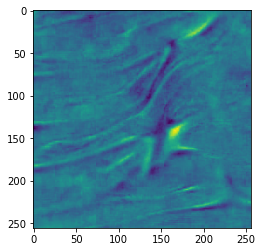

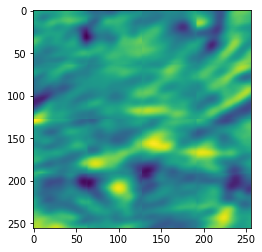

In [89]:
aaaa = ((dater[0][2*nn,0,100:356,150:406].squeeze()-dater[q+1][2*nn,0,100:356,150:406].squeeze())).squeeze()
plt.figure()
plt.imshow(aaaa)
plt.show()
plt.figure()
plt.imshow(vec.squeeze())
plt.show()

In [90]:
plt.close('all')

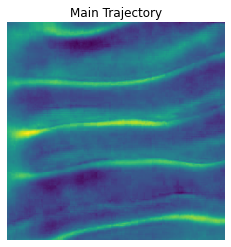

C:\Users\water\AppData\Local\Temp/ipykernel_3708/1533299528.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  thing[0,1:nvec] = vv[nn][vecn]


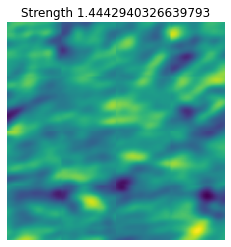

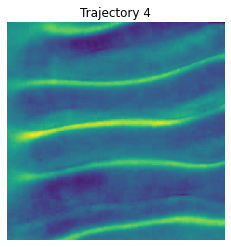

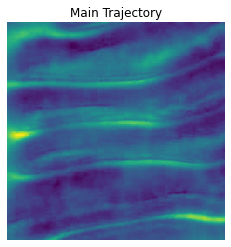

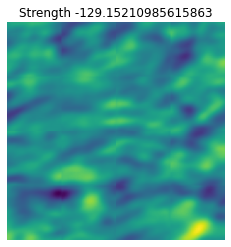

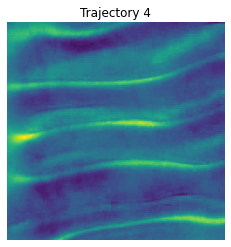

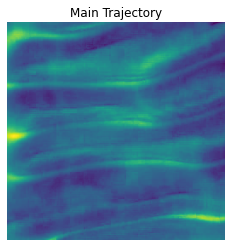

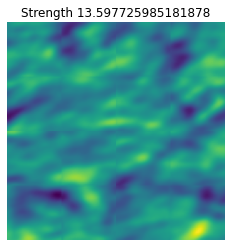

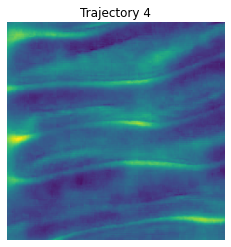

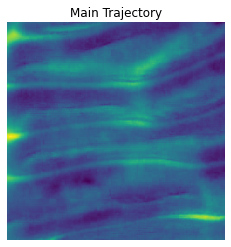

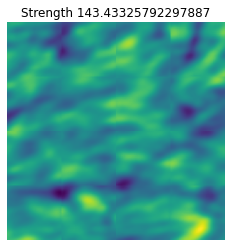

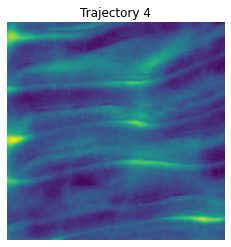

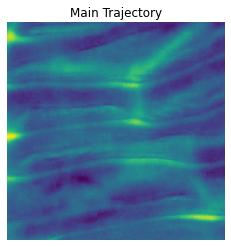

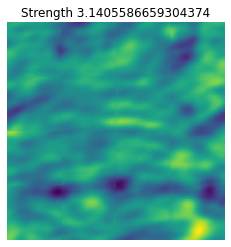

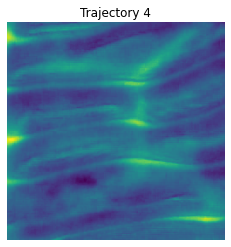

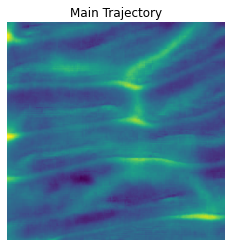

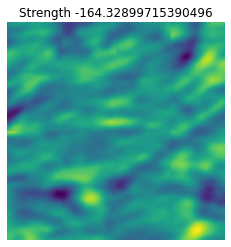

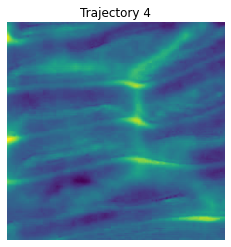

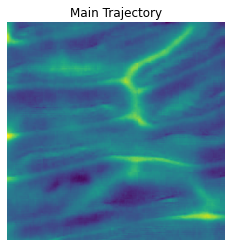

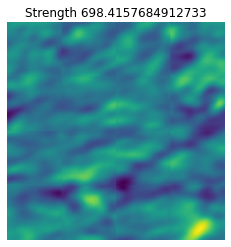

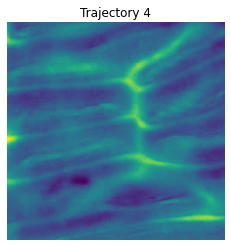

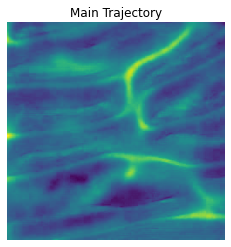

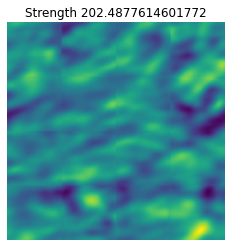

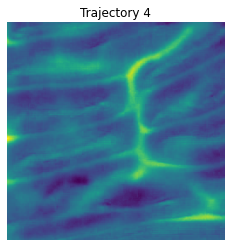

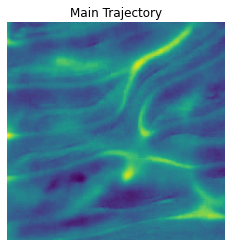

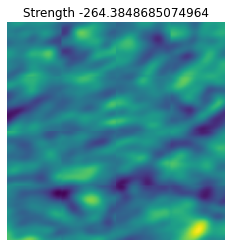

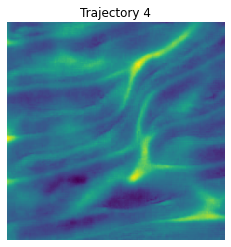

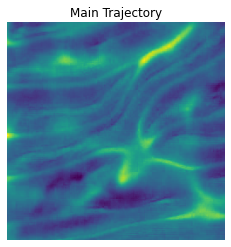

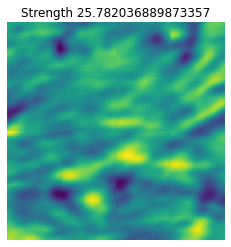

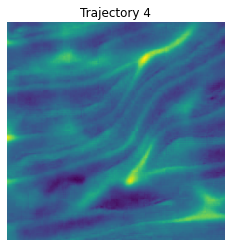

In [75]:
l = 5
ind=4
for nn in range(n,n+10):
    plt.figure()
    plt.imshow(dater[0][2*nn,0,100:356,150:406].squeeze())
    plt.title('Main Trajectory')
    plt.axis('off')
    plt.savefig(f"outputs/traj_{nn}.png")
    plt.show()
    comps = []
    for vecn in range(5):
        thing = np.zeros_like(daty[0:1])
        thing[0,1:nvec] = vv[nn][vecn]
        vec = pcap.reverse(thing)
        comp = np.sum((dater[0][2*nn,0,100:356,150:406].squeeze()-dater[q+1][2*nn,0,100:356,150:406].squeeze()).dot(vec))
        comps.append(comp)
        plt.figure()
        plt.title(f'Alignment {comp}')
        plt.imshow(vec.squeeze())#-dat[100].squeeze())
        plt.axis('off')
        plt.savefig(f"outputs/vec_{nn}_{vecn}.png")
        plt.show()
    veci = np.argmax(comps)
    aaaa = ((dater[0][2*nn,0,100:356,150:406].squeeze()-dater[q+1][2*nn,0,100:356,150:406].squeeze())).squeeze()
    plt.figure()
    plt.imshow(aaaa)
    plt.title(f'Diff_{nn}')
    plt.show()

    plt.figure()
    plt.imshow(dater[ind][2*(nn),0,100:356,150:406].squeeze())
    plt.title(f'Trajectory {ind}')
    plt.axis('off')
    plt.savefig(f"outputs/traj1_{nn}.png")
    plt.show()


C:\Users\water\AppData\Local\Temp/ipykernel_3708/2414320661.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  thing[0,1:32] = vv[n][vecn]


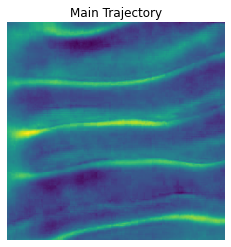

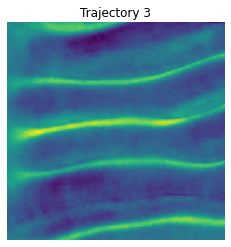

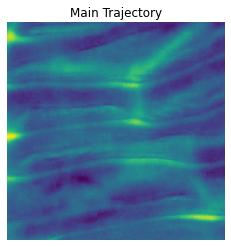

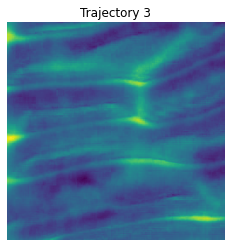

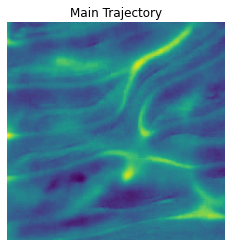

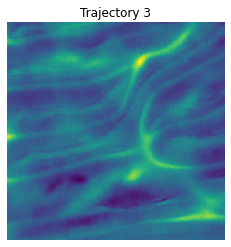

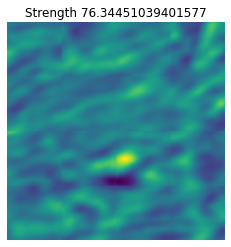

In [ ]:
vecn = 0
base = dats[n*2,0]
thing = np.zeros_like(daty[0:1])
thing[0,1:32] = vv[n][vecn]
vec = pcap.reverse(thing)
dots = []
for q in range(dats.shape[1]):
    dots.append(np.sum((dater[0][2*2*n,0,100:356,150:406].squeeze()-dater[q][2*2*n,0,100:356,150:406].squeeze()).dot(vec)))
ind = np.argmax(dots)

l = 3
for q in range(l):
    plt.figure()
    plt.imshow(dater[0][(2*2*n) + 8*q,0,100:356,150:406].squeeze())
    plt.title('Main Trajectory')
    plt.axis('off')
    #plt.savefig(f"data/traj{n}.png")
    plt.show()
    plt.figure()
    plt.imshow(dater[ind][(2*2*n) + 8*q,0,100:356,150:406].squeeze())
    plt.title(f'Trajectory {ind}')
    plt.axis('off')
    #plt.savefig(f"data/traj{n}.png")
    plt.show()

plt.figure()
plt.title(f'Strength {np.real(ve[n][vecn])}')
plt.imshow(r.squeeze())#-dat[100].squeeze())
plt.axis('off')
#plt.savefig(f"data/dir{n}_{q}.png")
plt.show()



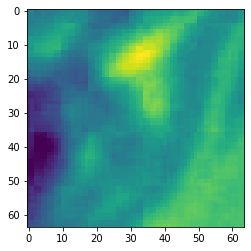

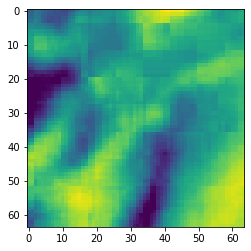

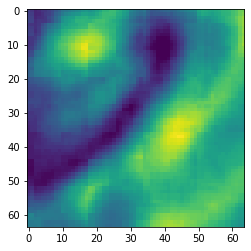

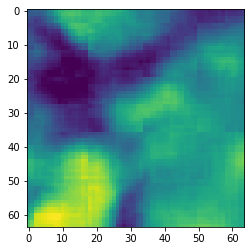

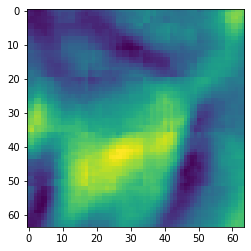

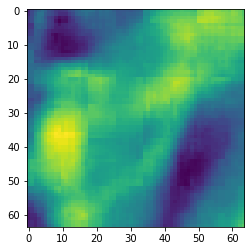

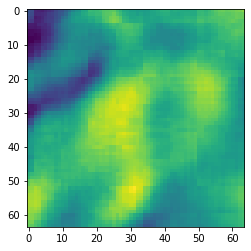

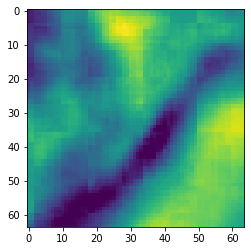

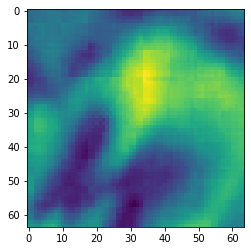

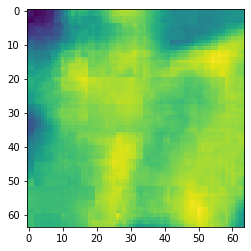

In [50]:
for q in range(0,100,10):
    plt.figure()
    plt.imshow(dat[mp+q,:,:,0])
    plt.show()

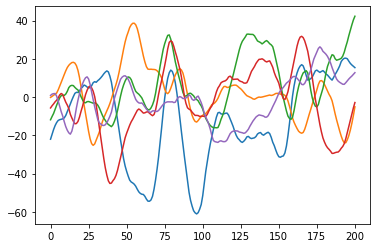

In [58]:
q=0
plt.figure()
plt.plot(svid[mq:(mq+lenny),q+0])
plt.plot(svid[mq:(mq+lenny),q+1])
plt.plot(svid[mq:(mq+lenny),q+2])
plt.plot(svid[mq:(mq+lenny),q+3])
plt.plot(svid[mq:(mq+lenny),q+4])
plt.show()

In [54]:
vid=dat
reduce=10
chipsize=8
n_components=8
x = vid.shape[1]
y = vid.shape[2]
c = chipsize
if not vid.shape[1]%chipsize == 0 or\
    not vid.shape[2]%chipsize == 0:
    print('get a better chipsize!')
tc = (x//c)*(y//c)
chips = np.zeros((vid.shape[0]*tc,c*c*vid.shape[3]))
for f in range(vid.shape[0]):
    grid = product(range(0, x-x%c, c), range(0, y-y%c, c))
    for n,ij in enumerate(grid):
        i,j = ij
        #chips[(f//reduce)*tc+n] = vid[f,i:(i+c),j:(j+c),:].flatten()
        chips[f*tc+n, :] = vid[f,i:(i+c),j:(j+c),:].flatten()
        #pdb.set_trace()
        #chips[f*tc+n,:] = copy.copy(vid[f,i:(i+c),j:(j+c),:].flatten())
chips.shape

(6558208, 64)

In [39]:
pca1.components_.shape

(12, 64)

In [48]:
128//8

16

In [45]:
np.where(np.max(chips,axis=1) == 0)[0][0]

256

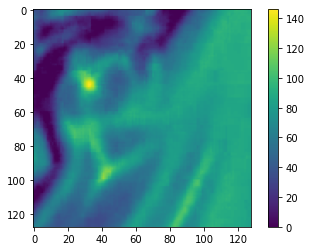

In [51]:
plt.figure()
plt.imshow(vid[50,:,:,0])
plt.colorbar()
plt.show()

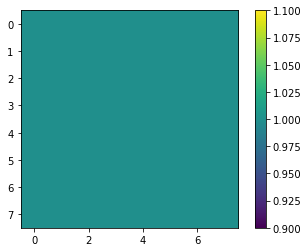

In [52]:
plt.figure()
plt.imshow(chips[16*16*50+3,:].reshape([8,8]))
plt.imshow(chips[250,:].reshape([8,8]))
plt.colorbar()
plt.show()

In [ ]:
pca = skd.PCA(n_components=n_components)
if reduce > 1:
    pca.fit(chips[::reduce])
    chips = pca.transform(chips)
else:
    chips = pca.fit_transform(chips)
chips
